In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import os

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Для воспроизводимости
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Создаем папку для сохранения результатов, если ее нет
output_dir = "vae_lab_results"
os.makedirs(output_dir, exist_ok=True)

Using device: cuda


# 1. Подготовка данных

In [50]:
# Трансформации: нормализация к [0,1]
transform = transforms.Compose([
    transforms.ToTensor(), # Преобразует PIL Image или numpy.ndarray в FloatTensor и масштабирует до [0.0, 1.0]
])

# Загрузка датасета MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер тестовой выборки: {len(test_dataset)}")
print(f"Размер батча: {batch_size}")

Размер обучающей выборки: 60000
Размер тестовой выборки: 10000
Размер батча: 128


In [52]:
def visualize_mnist_samples(dataset, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze().numpy(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.suptitle("Примеры изображений MNIST")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #plt.savefig(os.path.join(output_dir, "mnist_samples.png"))
    plt.show()

# 3. Реализация автокодировщика (AE)

In [54]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=20):
        super(Autoencoder, self).__init__()
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        # Декодер
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid() # Sigmoid для выходных пикселей в диапазоне [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [96]:
def visualize_reconstruction(model, data_loader, num_images=10, title="Реконструкция"):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(data_loader))
        # Убедимся, что берем только нужное количество изображений
        data = data[:num_images].view(-1, input_dim).to(device)

        if isinstance(model, VAE):
            reconstruction, _, _ = model(data)
        else: # Для Autoencoder
            reconstruction = model(data)

        fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
        for i in range(num_images):
            # Оригинальное изображение
            axes[0, i].imshow(data[i].cpu().reshape(28, 28), cmap='gray')
            axes[0, i].set_title("Original")
            axes[0, i].axis('off')
            # Реконструированное изображение
            # reconstruction[i] уже является отдельным изображением (размер 784)
            axes[1, i].imshow(reconstruction[i].cpu().reshape(28, 28), cmap='gray')
            axes[1, i].set_title("Reconstructed")
            axes[1, i].axis('off')
        plt.suptitle(title)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(os.path.join(output_dir, f"{title.lower().replace(' ', '_')}.png"))
        plt.show()

In [58]:
input_dim = 28 * 28
latent_dim_ae = 20 # Размерность латентного пространства для AE
num_epochs_ae = 20
learning_rate_ae = 1e-3

ae_model = Autoencoder(input_dim, latent_dim_ae).to(device)
ae_optimizer = optim.Adam(ae_model.parameters(), lr=learning_rate_ae)
ae_criterion = nn.MSELoss() # MSE для реконструкции

train_losses_ae = []
test_losses_ae = []

In [60]:
print(f"Начинаем обучение AE на {num_epochs_ae} эпохах...")
for epoch in range(num_epochs_ae):
    ae_model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_dim).to(device)
        ae_optimizer.zero_grad()
        reconstruction = ae_model(data)
        loss = ae_criterion(reconstruction, data)
        loss.backward()
        ae_optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses_ae.append(avg_train_loss)

    ae_model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(-1, input_dim).to(device)
            reconstruction = ae_model(data)
            loss = ae_criterion(reconstruction, data)
            test_loss += loss.item()
    avg_test_loss = test_loss / len(test_loader)
    test_losses_ae.append(avg_test_loss)

    print(f"Эпоха [{epoch+1}/{num_epochs_ae}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

Начинаем обучение AE на 20 эпохах...
Эпоха [1/20], Train Loss: 0.0499, Test Loss: 0.0278
Эпоха [2/20], Train Loss: 0.0242, Test Loss: 0.0205
Эпоха [3/20], Train Loss: 0.0192, Test Loss: 0.0173
Эпоха [4/20], Train Loss: 0.0163, Test Loss: 0.0149
Эпоха [5/20], Train Loss: 0.0144, Test Loss: 0.0134
Эпоха [6/20], Train Loss: 0.0131, Test Loss: 0.0123
Эпоха [7/20], Train Loss: 0.0121, Test Loss: 0.0114
Эпоха [8/20], Train Loss: 0.0114, Test Loss: 0.0111
Эпоха [9/20], Train Loss: 0.0109, Test Loss: 0.0104
Эпоха [10/20], Train Loss: 0.0104, Test Loss: 0.0101
Эпоха [11/20], Train Loss: 0.0100, Test Loss: 0.0098
Эпоха [12/20], Train Loss: 0.0097, Test Loss: 0.0095
Эпоха [13/20], Train Loss: 0.0093, Test Loss: 0.0092
Эпоха [14/20], Train Loss: 0.0091, Test Loss: 0.0090
Эпоха [15/20], Train Loss: 0.0089, Test Loss: 0.0089
Эпоха [16/20], Train Loss: 0.0087, Test Loss: 0.0087
Эпоха [17/20], Train Loss: 0.0085, Test Loss: 0.0085
Эпоха [18/20], Train Loss: 0.0084, Test Loss: 0.0084
Эпоха [19/20], Tra

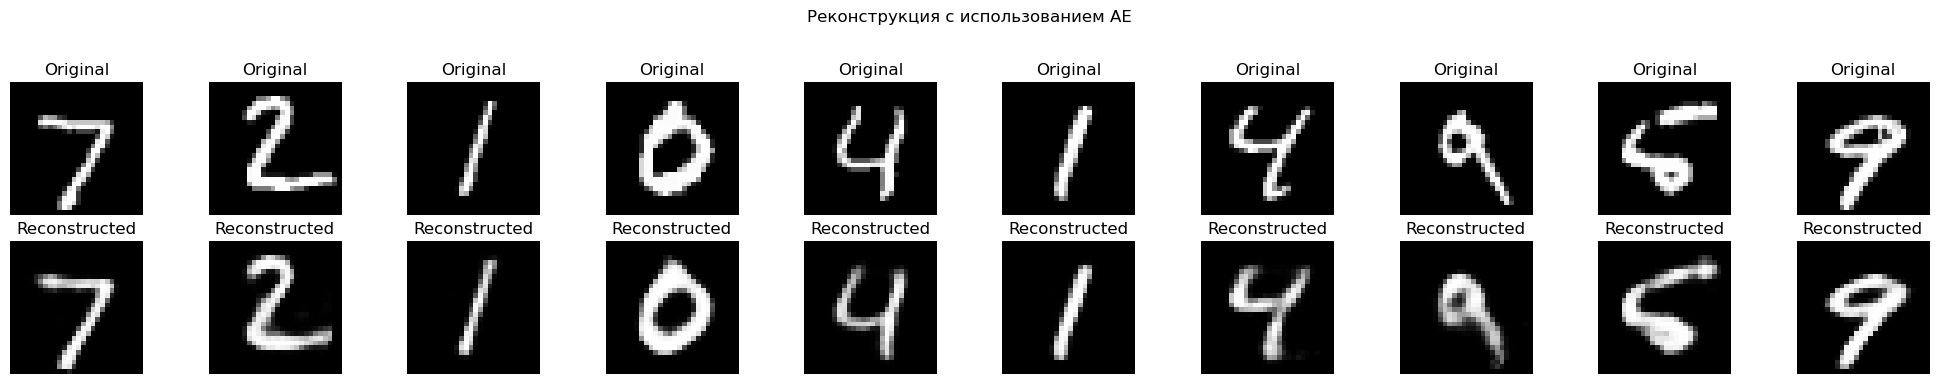

In [62]:
visualize_reconstruction(ae_model, test_loader, num_images=10, title="Реконструкция с использованием AE")

# 4. Реализация вариационного автокодировщика (VAE)

In [64]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=20):
        super(VAE, self).__init__()
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # Декодер
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid() # Sigmoid для выходных пикселей в диапазоне [0,1]
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # Сэмплируем из N(0,1)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z)
        return reconstruction, mu, logvar

In [66]:
def vae_loss_function(recon_x, x, mu, logvar):
    # BCE реконструкционная ошибка
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, input_dim), reduction='sum')

    # KL-дивергенция
    # KL = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KL_D = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KL_D

In [68]:
def visualize_latent_space(model, data_loader, num_samples=5000):
    model.eval()
    latent_points = []
    labels = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(data_loader):
            data = data.view(-1, input_dim).to(device)
            mu, logvar = model.encode(data)
            # Мы визуализируем mu, так как это среднее нашего распределения в латентном пространстве
            latent_points.append(mu.cpu().numpy())
            labels.append(label.cpu().numpy())
            if len(latent_points) * batch_size >= num_samples:
                break
    
    latent_points = np.vstack(latent_points)[:num_samples]
    labels = np.concatenate(labels)[:num_samples]

    if latent_dim_vae >= 2:
        if latent_dim_vae > 2:
            # Используем PCA для уменьшения до 2D для визуализации
            pca = PCA(n_components=2)
            latent_points_2d = pca.fit_transform(latent_points)
        else:
            latent_points_2d = latent_points

        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latent_points_2d[:, 0], latent_points_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
        plt.colorbar(scatter, ticks=range(10), label='Цифра')
        plt.title("Визуализация латентного пространства VAE (PCA до 2D, если dim > 2)")
        plt.xlabel("Первая главная компонента / Латентная ось 1")
        plt.ylabel("Вторая главная компонента / Латентная ось 2")
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, "vae_latent_space.png"))
        plt.show()
    else:
        print("Размерность латентного пространства слишком мала для 2D визуализации.")

In [70]:
latent_dim_vae = 20 # Размерность латентного пространства для VAE
num_epochs_vae = 20
learning_rate_vae = 1e-3

vae_model = VAE(input_dim, latent_dim_vae).to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate_vae)

train_losses_vae = []
test_losses_vae = []
train_recon_losses_vae = []
train_kl_losses_vae = []
test_recon_losses_vae = []
test_kl_losses_vae = []

In [72]:
print(f"Начинаем обучение VAE на {num_epochs_vae} эпохах...")
for epoch in range(num_epochs_vae):
    vae_model.train()
    train_loss = 0
    train_recon_loss_sum = 0
    train_kl_loss_sum = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_dim).to(device)
        vae_optimizer.zero_grad()
        reconstruction, mu, logvar = vae_model(data)
        loss = vae_loss_function(reconstruction, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()

        # Разделяем потери для анализа
        BCE = nn.functional.binary_cross_entropy(reconstruction, data.view(-1, input_dim), reduction='sum')
        KL_D = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        train_recon_loss_sum += BCE.item()
        train_kl_loss_sum += KL_D.item()

        vae_optimizer.step()

    avg_train_loss = train_loss / len(train_dataset) # Делим на количество образцов, а не батчей, так как loss - сумма
    avg_train_recon_loss = train_recon_loss_sum / len(train_dataset)
    avg_train_kl_loss = train_kl_loss_sum / len(train_dataset)
    train_losses_vae.append(avg_train_loss)
    train_recon_losses_vae.append(avg_train_recon_loss)
    train_kl_losses_vae.append(avg_train_kl_loss)


    vae_model.eval()
    test_loss = 0
    test_recon_loss_sum = 0
    test_kl_loss_sum = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(-1, input_dim).to(device)
            reconstruction, mu, logvar = vae_model(data)
            loss = vae_loss_function(reconstruction, data, mu, logvar)
            test_loss += loss.item()

            BCE = nn.functional.binary_cross_entropy(reconstruction, data.view(-1, input_dim), reduction='sum')
            KL_D = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            test_recon_loss_sum += BCE.item()
            test_kl_loss_sum += KL_D.item()

    avg_test_loss = test_loss / len(test_dataset)
    avg_test_recon_loss = test_recon_loss_sum / len(test_dataset)
    avg_test_kl_loss = test_kl_loss_sum / len(test_dataset)
    test_losses_vae.append(avg_test_loss)
    test_recon_losses_vae.append(avg_test_recon_loss)
    test_kl_losses_vae.append(avg_test_kl_loss)

    print(f"Эпоха [{epoch+1}/{num_epochs_vae}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, "
          f"Train Recon Loss: {avg_train_recon_loss:.4f}, Train KL Loss: {avg_train_kl_loss:.4f}")

Начинаем обучение VAE на 20 эпохах...
Эпоха [1/20], Train Loss: 191.3782, Test Loss: 153.7560, Train Recon Loss: 185.1000, Train KL Loss: 6.2782
Эпоха [2/20], Train Loss: 140.1695, Test Loss: 129.0338, Train Recon Loss: 126.1380, Train KL Loss: 14.0316
Эпоха [3/20], Train Loss: 124.2489, Test Loss: 119.1505, Train Recon Loss: 107.5897, Train KL Loss: 16.6592
Эпоха [4/20], Train Loss: 117.5152, Test Loss: 114.1702, Train Recon Loss: 99.6807, Train KL Loss: 17.8345
Эпоха [5/20], Train Loss: 113.9359, Test Loss: 112.0504, Train Recon Loss: 95.4999, Train KL Loss: 18.4361
Эпоха [6/20], Train Loss: 111.6114, Test Loss: 109.6387, Train Recon Loss: 92.8016, Train KL Loss: 18.8099
Эпоха [7/20], Train Loss: 109.9898, Test Loss: 108.6280, Train Recon Loss: 90.9247, Train KL Loss: 19.0651
Эпоха [8/20], Train Loss: 108.8297, Test Loss: 107.6427, Train Recon Loss: 89.5901, Train KL Loss: 19.2396
Эпоха [9/20], Train Loss: 107.8174, Test Loss: 107.1821, Train Recon Loss: 88.3979, Train KL Loss: 19.41

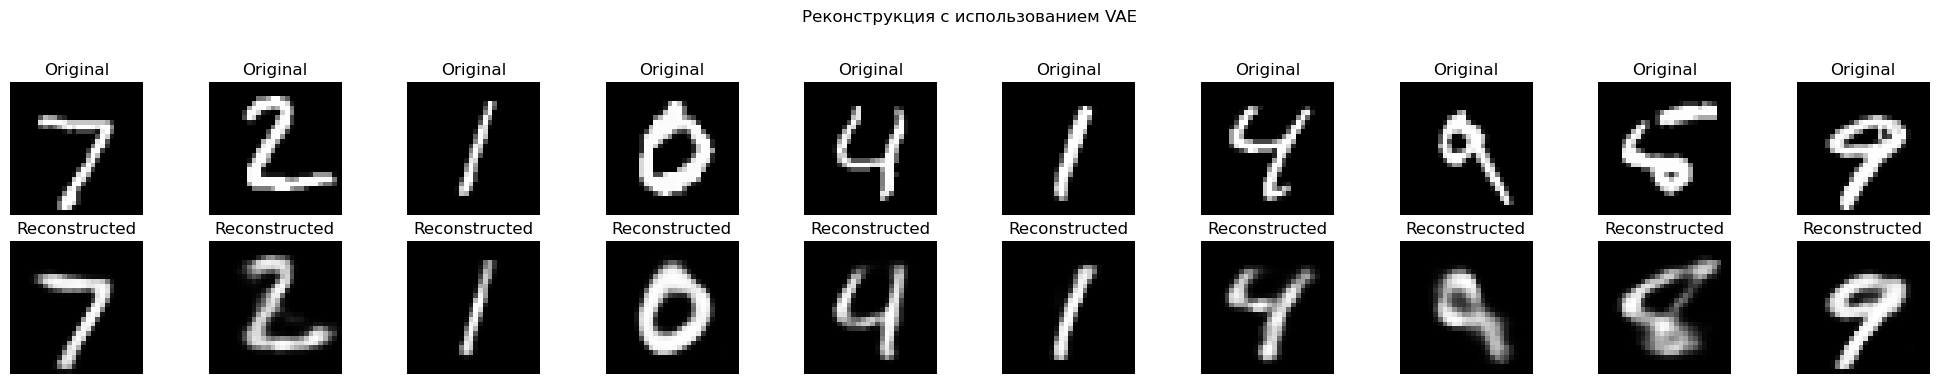

In [98]:
visualize_reconstruction(vae_model, test_loader, title="Реконструкция с использованием VAE")

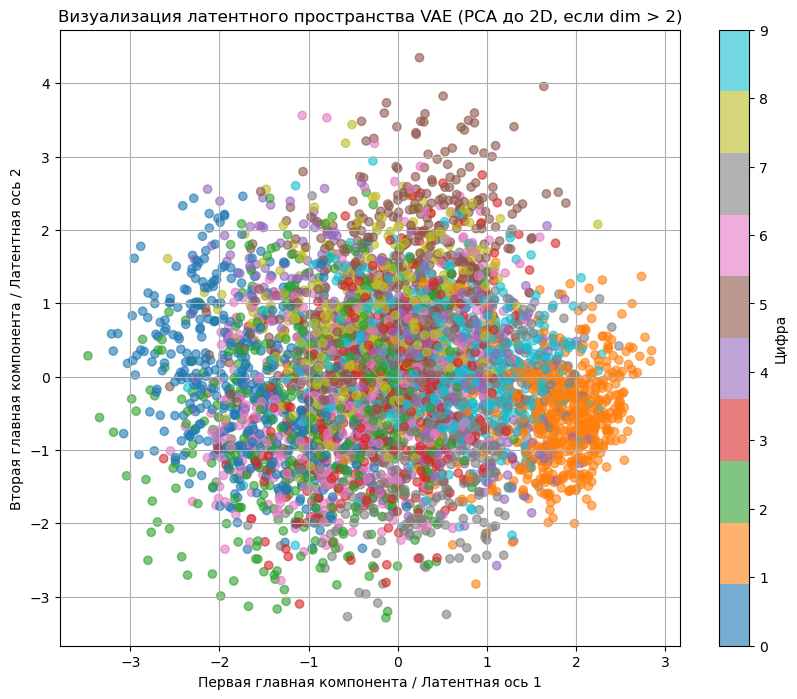

In [76]:
visualize_latent_space(vae_model, test_loader)

# 5. Сравнение PCA, AE и VAE

## Реализация PCA

In [80]:
def reconstruct_with_pca(data, n_components):
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(data)
    reconstructed_data = pca.inverse_transform(transformed_data)
    return reconstructed_data, pca

# Подготовка данных для PCA
# Берем данные из test_dataset
test_images_flat = torch.stack([img for img, _ in test_dataset]).view(-1, input_dim).numpy()

# Выберем аналогичную размерность для PCA для честного сравнения
latent_dim_for_pca = latent_dim_vae # Используем ту же размерность, что и для VAE/AE

print(f"Реконструкция с PCA с {latent_dim_for_pca} компонентами...")
reconstructed_pca, pca_model = reconstruct_with_pca(test_images_flat, latent_dim_for_pca)

Реконструкция с PCA с 20 компонентами...


In [82]:
def visualize_pca_reconstruction(original_data, reconstructed_data, num_images=10):
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):
        axes[0, i].imshow(original_data[i].reshape(28, 28), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_data[i].reshape(28, 28), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.suptitle("Реконструкция с использованием PCA")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(output_dir, "pca_reconstruction.png"))
    plt.show()

In [84]:
# Визуализация латентного пространства для PCA (по аналогии с VAE)
def visualize_pca_latent_space(pca_model, original_data, labels, num_samples=5000):
    transformed_data = pca_model.transform(original_data)[:num_samples]
    labels_subset = labels[:num_samples]

    if pca_model.n_components >= 2:
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=labels_subset, cmap='tab10', alpha=0.6)
        plt.colorbar(scatter, ticks=range(10), label='Цифра')
        plt.title("Визуализация латентного пространства PCA (Первые 2 компоненты)")
        plt.xlabel("Первая главная компонента")
        plt.ylabel("Вторая главная компонента")
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, "pca_latent_space.png"))
        plt.show()
    else:
        print("PCA имеет слишком мало компонент для 2D визуализации латентного пространства.")

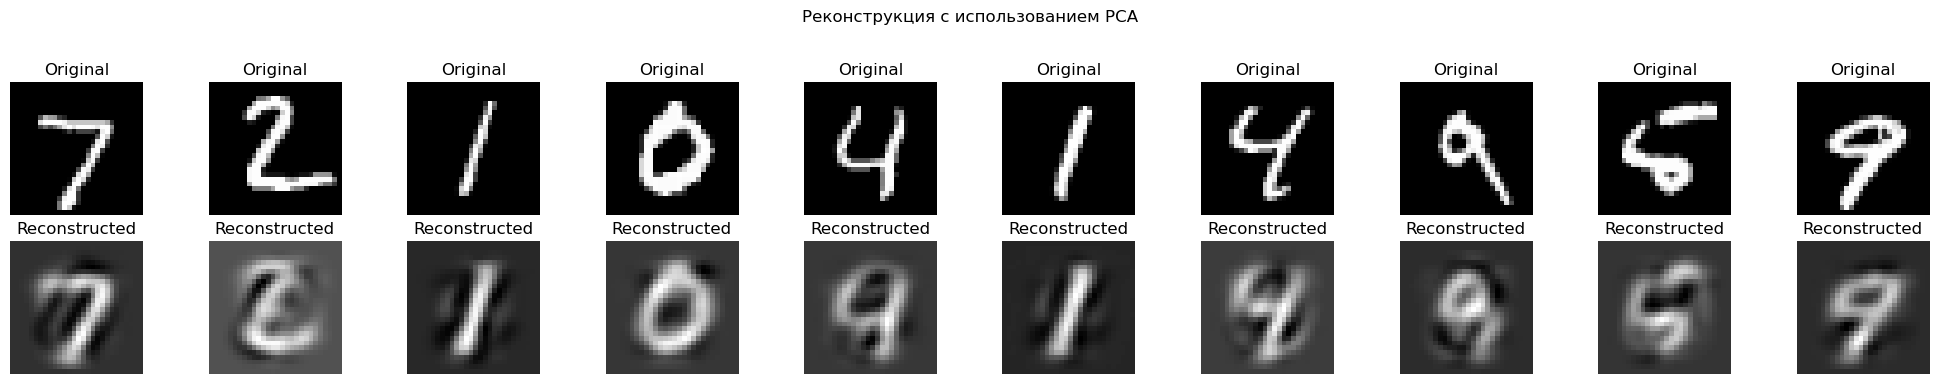

In [86]:
visualize_pca_reconstruction(test_images_flat, reconstructed_pca, num_images=10)

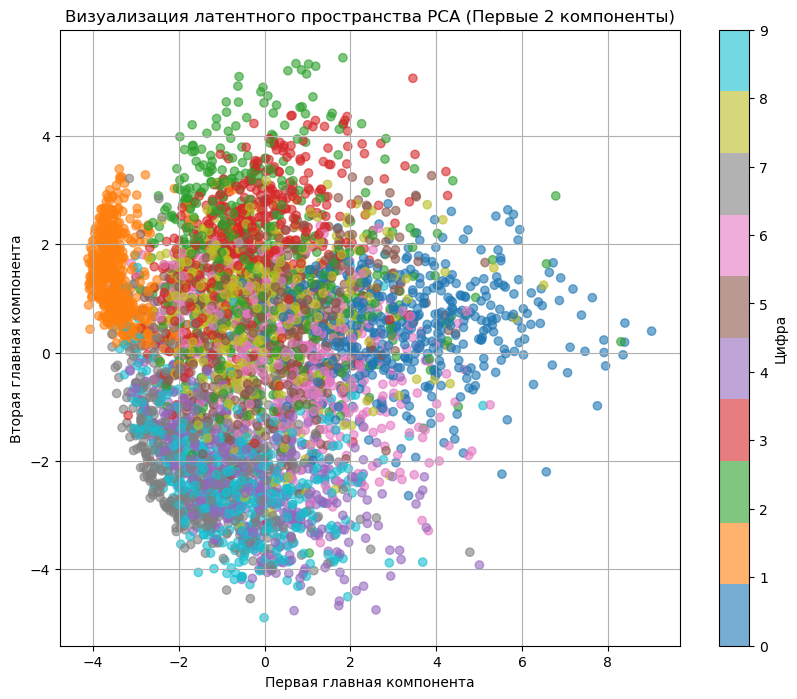

In [100]:
# Получаем метки для визуализации PCA латентного пространства
test_labels = torch.stack([torch.tensor(label) for _, label in test_dataset]).numpy()
visualize_pca_latent_space(pca_model, test_images_flat, test_labels)

## Сравнение

In [90]:
# MSE для PCA
mse_pca = mean_squared_error(test_images_flat, reconstructed_pca)
print(f"MSE реконструкции для PCA: {mse_pca:.6f}")

# MSE для AE
ae_model.eval()
test_data_ae = next(iter(test_loader))[0].view(-1, input_dim).to(device)
reconstructed_ae = ae_model(test_data_ae).cpu().detach().numpy()
mse_ae = mean_squared_error(test_data_ae.cpu().numpy(), reconstructed_ae)
print(f"MSE реконструкции для AE: {mse_ae:.6f}")

# MSE для VAE (используем только реконструкцию без KL)
vae_model.eval()
test_data_vae = next(iter(test_loader))[0].view(-1, input_dim).to(device)
reconstructed_vae, _, _ = vae_model(test_data_vae)
mse_vae = mean_squared_error(test_data_vae.cpu().numpy(), reconstructed_vae.cpu().detach().numpy())
print(f"MSE реконструкции для VAE: {mse_vae:.6f}")

MSE реконструкции для PCA: 0.023373
MSE реконструкции для AE: 0.008208
MSE реконструкции для VAE: 0.014943


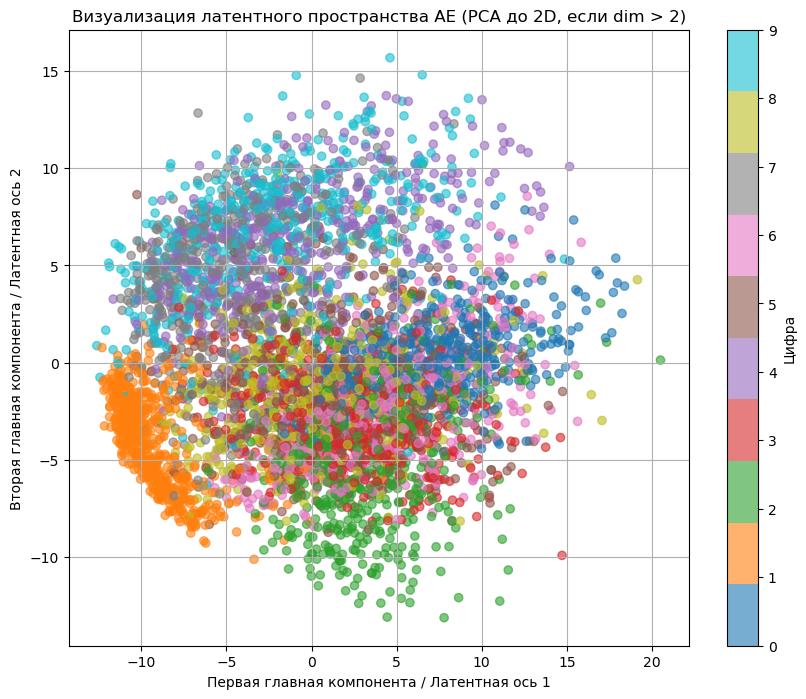

In [92]:
# Для AE нет "гладкого" латентного пространства как у VAE,
# но мы можем визуализировать его, чтобы понять, как оно кластеризует данные.
def visualize_ae_latent_space(model, data_loader, num_samples=5000):
    model.eval()
    latent_points = []
    labels = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(data_loader):
            data = data.view(-1, input_dim).to(device)
            encoded = model.encoder(data)
            latent_points.append(encoded.cpu().numpy())
            labels.append(label.cpu().numpy())
            if len(latent_points) * batch_size >= num_samples:
                break
    
    latent_points = np.vstack(latent_points)[:num_samples]
    labels = np.concatenate(labels)[:num_samples]

    if latent_dim_ae >= 2:
        if latent_dim_ae > 2:
            # Используем PCA для уменьшения до 2D для визуализации
            pca = PCA(n_components=2)
            latent_points_2d = pca.fit_transform(latent_points)
        else:
            latent_points_2d = latent_points

        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latent_points_2d[:, 0], latent_points_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
        plt.colorbar(scatter, ticks=range(10), label='Цифра')
        plt.title("Визуализация латентного пространства AE (PCA до 2D, если dim > 2)")
        plt.xlabel("Первая главная компонента / Латентная ось 1")
        plt.ylabel("Вторая главная компонента / Латентная ось 2")
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, "ae_latent_space.png"))
        plt.show()
    else:
        print("Размерность латентного пространства AE слишком мала для 2D визуализации.")

visualize_ae_latent_space(ae_model, test_loader)

# 6. Генерация данных

In [102]:
def generate_images_from_latent_space(model, latent_dim, num_images=10):
    model.eval()
    with torch.no_grad():
        # Сэмплируем из стандартного нормального распределения
        z = torch.randn(num_images, latent_dim).to(device)
        generated_images = model.decode(z).cpu()

        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
        for i in range(num_images):
            axes[i].imshow(generated_images[i].reshape(28, 28), cmap='gray')
            axes[i].axis('off')
        plt.suptitle("Генерация изображений из случайных точек латентного пространства VAE")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(os.path.join(output_dir, "vae_generated_images.png"))
        plt.show()

Генерация случайных изображений VAE...


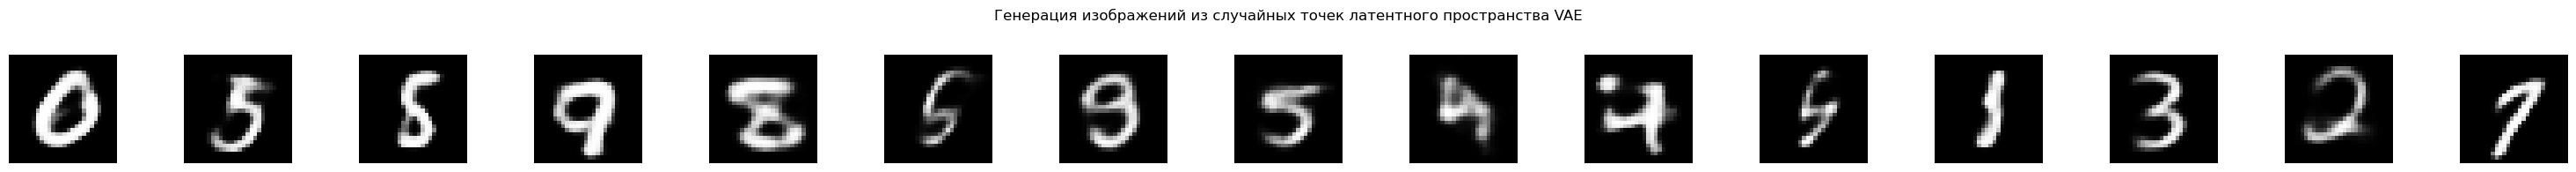

In [104]:
print("Генерация случайных изображений VAE...")
generate_images_from_latent_space(vae_model, latent_dim_vae, num_images=15)

Интерполяция в латентном пространстве VAE...


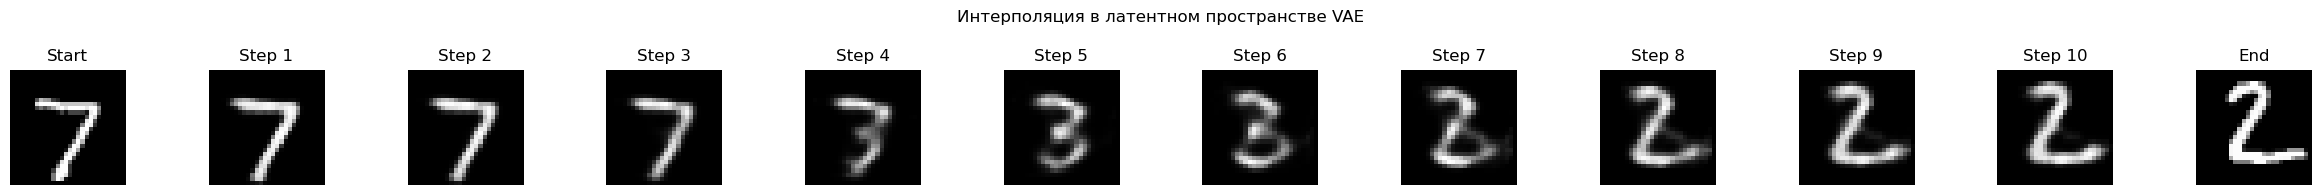

In [106]:
# Проведите интерполяцию между двумя точками латентного пространства
def interpolate_latent_space(model, latent_dim, start_image_idx=0, end_image_idx=1, num_steps=10):
    model.eval()
    with torch.no_grad():
        # Берем две случайные точки из тестового набора
        data, _ = next(iter(test_loader))
        data = data.view(-1, input_dim).to(device)

        # Кодируем их в латентное пространство
        mu1, _ = model.encode(data[start_image_idx].unsqueeze(0))
        mu2, _ = model.encode(data[end_image_idx].unsqueeze(0))

        interpolated_images = []
        for i in range(num_steps):
            alpha = i / (num_steps - 1)
            interpolated_z = mu1 * (1 - alpha) + mu2 * alpha
            generated_image = model.decode(interpolated_z).cpu().reshape(28, 28)
            interpolated_images.append(generated_image)

        fig, axes = plt.subplots(1, num_steps + 2, figsize=((num_steps + 2) * 2, 2))
        
        # Оригинальное начальное изображение
        axes[0].imshow(data[start_image_idx].cpu().reshape(28, 28), cmap='gray')
        axes[0].set_title("Start")
        axes[0].axis('off')

        for i, img in enumerate(interpolated_images):
            axes[i+1].imshow(img, cmap='gray')
            axes[i+1].set_title(f"Step {i+1}")
            axes[i+1].axis('off')

        # Оригинальное конечное изображение
        axes[num_steps + 1].imshow(data[end_image_idx].cpu().reshape(28, 28), cmap='gray')
        axes[num_steps + 1].set_title("End")
        axes[num_steps + 1].axis('off')

        plt.suptitle("Интерполяция в латентном пространстве VAE")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(os.path.join(output_dir, "vae_interpolation.png"))
        plt.show()

print("Интерполяция в латентном пространстве VAE...")
interpolate_latent_space(vae_model, latent_dim_vae)

# 8. Анализ результатов


8. Анализ результатов:


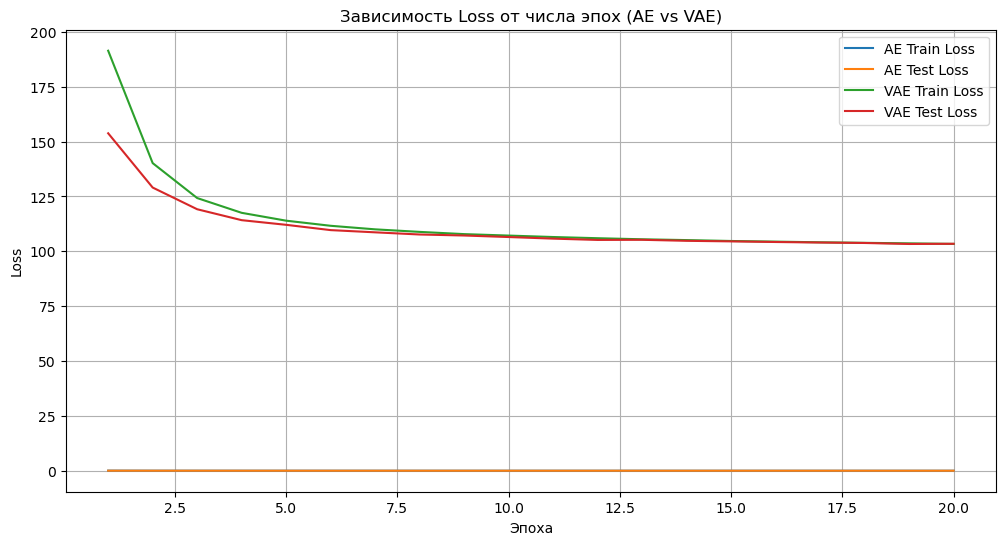

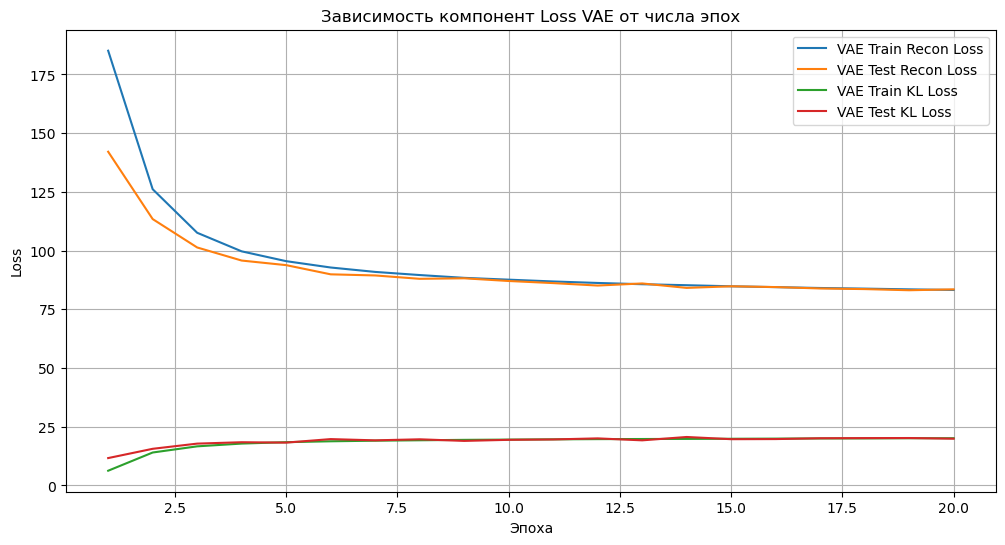


Сравнение MSE реконструкции:
PCA (latent_dim=20): 0.023373
AE (latent_dim=20):   0.008208
VAE (latent_dim=20):  0.014943


In [108]:
# 8. Анализ результатов:
print("\n8. Анализ результатов:")

# Постройте графики зависимости метрик качества от числа эпох для AE и VAE
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs_ae + 1), train_losses_ae, label='AE Train Loss')
plt.plot(range(1, num_epochs_ae + 1), test_losses_ae, label='AE Test Loss')
plt.plot(range(1, num_epochs_vae + 1), train_losses_vae, label='VAE Train Loss')
plt.plot(range(1, num_epochs_vae + 1), test_losses_vae, label='VAE Test Loss')
plt.title("Зависимость Loss от числа эпох (AE vs VAE)")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "loss_vs_epochs_ae_vae.png"))
plt.show()

# Графики реконструкционной ошибки и KL-дивергенции для VAE
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs_vae + 1), train_recon_losses_vae, label='VAE Train Recon Loss')
plt.plot(range(1, num_epochs_vae + 1), test_recon_losses_vae, label='VAE Test Recon Loss')
plt.plot(range(1, num_epochs_vae + 1), train_kl_losses_vae, label='VAE Train KL Loss')
plt.plot(range(1, num_epochs_vae + 1), test_kl_losses_vae, label='VAE Test KL Loss')
plt.title("Зависимость компонент Loss VAE от числа эпох")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "vae_loss_components_vs_epochs.png"))
plt.show()

# Таблица сравнения MSE реконструкции
print("\nСравнение MSE реконструкции:")
print(f"PCA (latent_dim={latent_dim_for_pca}): {mse_pca:.6f}")
print(f"AE (latent_dim={latent_dim_ae}):   {mse_ae:.6f}")
print(f"VAE (latent_dim={latent_dim_vae}):  {mse_vae:.6f}")